In [14]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Load datasets 

In [2]:
df_train = pd.read_csv('train.tsv',sep = '\t')
df_test = pd.read_csv('test.tsv',sep = '\t')

In [3]:
df_train.head(5)

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,1,1,14,0,12032,162,10,0.098765,0.082569,0


In [4]:
columns = df_train.columns

In [5]:
columns

Index(['url', 'urlid', 'boilerplate', 'alchemy_category',
       'alchemy_category_score', 'avglinksize', 'commonlinkratio_1',
       'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
       'compression_ratio', 'embed_ratio', 'framebased', 'frameTagRatio',
       'hasDomainLink', 'html_ratio', 'image_ratio', 'is_news',
       'lengthyLinkDomain', 'linkwordscore', 'news_front_page',
       'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
       'parametrizedLinkRatio', 'spelling_errors_ratio', 'label'],
      dtype='object')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'business'),
  Text(1, 0, 'recreation'),
  Text(2, 0, 'health'),
  Text(3, 0, 'sports'),
  Text(4, 0, '?'),
  Text(5, 0, 'arts_entertainment'),
  Text(6, 0, 'science_technology'),
  Text(7, 0, 'gaming'),
  Text(8, 0, 'culture_politics'),
  Text(9, 0, 'computer_internet'),
  Text(10, 0, 'law_crime'),
  Text(11, 0, 'religion'),
  Text(12, 0, 'weather'),
  Text(13, 0, 'unknown')])

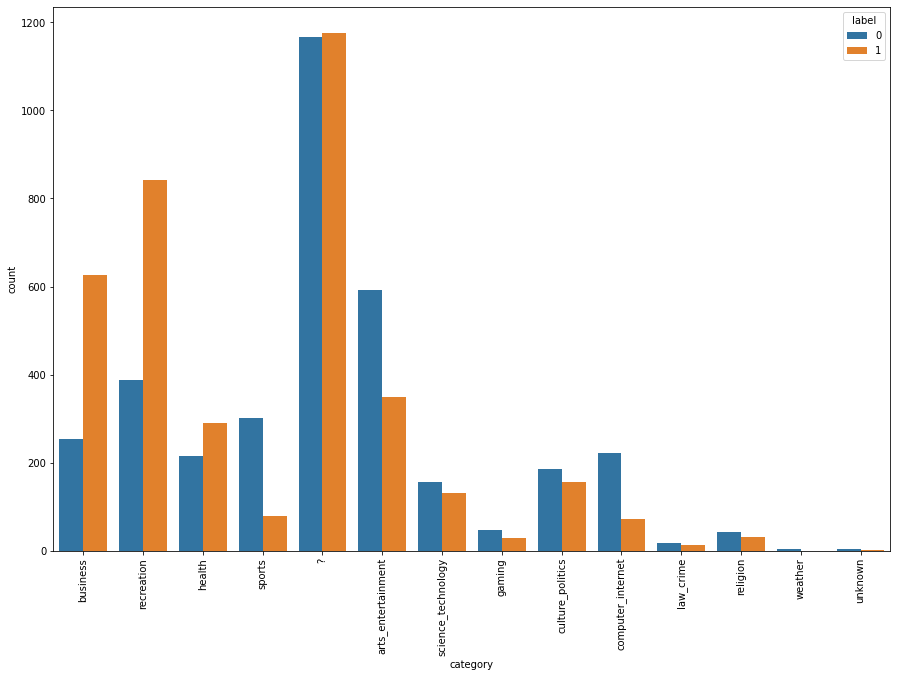

In [6]:
plt.figure(figsize = (15,10))
sns.countplot(x = df_train['alchemy_category'],hue = df_train['label'])
plt.xlabel('category')
plt.xticks(rotation = 90)

In [7]:
df_train['boilerplate'][1]

'{"title":"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races","body":"And that can be carried on a plane without the hassle too The Omega E Gun Starting Pistol Omega It s easy to take for granted just how insanely close some Olympic races are and how much the minutiae of it all can matter The perfect example is the traditional starting gun Seems easy You pull a trigger and the race starts Boom What people don t consider When a conventional gun goes off the sound travels to the ears of the closest runner a fraction of a second sooner than the others That s just enough to matter and why the latest starting pistol has traded in the mechanical boom for orchestrated electronic noise Omega has been the watch company tasked as the official timekeeper of the Olympic Games since 1932 At the 2010 Vancouv

In [8]:
df_train['boilerplate'].replace(to_replace = r'"title":',value = '',inplace = True, regex = True)
df_train['boilerplate'].replace(to_replace = r'"url":',value = '',inplace = True, regex = True)
df_train['boilerplate'].replace(to_replace = r'"{|}":',value = '',inplace = True, regex = True)
df_train['boilerplate'] = df_train['boilerplate'].str.lower()

In [9]:
#Cleaning the test dataframe 

df_test['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_test['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)

df_test['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
df_test['boilerplate']=df_test['boilerplate'].str.lower()

In [10]:
from transformers import AutoTokenizer


#Downloading the tokenizer and the Albert model for fine tuning

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [15]:
SEQ_length=512

Xids = np.zeros((df_train.shape[0],SEQ_length))
Xmask = np.zeros((df_train.shape[0],SEQ_length))
y=np.zeros((df_train.shape[0],1))

#Preparing the test dataframe

Xids_test=np.zeros((df_test.shape[0],SEQ_length))
Xmask_test=np.zeros((df_test.shape[0],SEQ_length))


In [18]:
Xids

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
for i,sequence in enumerate(df_train['boilerplate']):
    tokens = tokenizer.encode_plus(sequence,max_length = SEQ_length,padding = 'max_length',add_special_tokens = True,truncation=True,return_token_type_ids=False,return_attention_mask=True,
                           return_tensors='tf')
    Xids[i,:],Xmask[i,:],y[i,0] = tokens['input_ids'],tokens['attention_mask'],df_train.loc[i,'label']

In [20]:
for i,sequence in enumerate(df_test['boilerplate']):
    tokens=tokenizer.encode_plus(sequence,max_length=SEQ_length,padding='max_length',add_special_tokens=True,
                           truncation=True,return_token_type_ids=False,return_attention_mask=True,
                           return_tensors='tf')
    
    Xids_test[i,:],Xmask_test[i,:]=tokens['input_ids'],tokens['attention_mask']

In [27]:
dataset= tf.data.Dataset.from_tensor_slices((Xids,Xmask,y))#传入的shape 会生成个数为Xids的（Xmask,y）size的数据

def map_func(input_ids,mask,labels):
    return {'input_ids':input_ids,'attention_mask':mask},labels

dataset = dataset.map(map_func)
dataset = dataset.shuffle(100000).batch(64).prefetch(1000)

DS_size = len(list(dataset))

In [28]:
train=dataset.take(round(DS_size*0.90))
val=dataset.skip(round(DS_size*0.90))

In [29]:
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test,Xmask_test))
def map_func_test(input_ids,mask):
    return{'input_ids':input_ids,'attention_mask':mask}

dataset_test = dataset_test.map(map_func_test)
dataset_test = dataset_test.batch(64).prefetch(1000)

In [32]:
from transformers import TFDistilBertModel, DistilBertConfig
distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig(dropout=0.4,attention_dropout=0.4)
config.output_hidden_states = False
transformer_model = TFDistilBertModel.from_pretrained(distil_bert,config = config)

input_ids_in  = tf.keras.layers.Input(shape=(SEQ_length),name = 'input_ids',dtype ='int32')
input_masks_in = tf.keras.layers.Input(shape = (SEQ_length),name = 'attention_mask',dtype='int32')

embedding_layer = transformer_model(input_ids_in,attention_mask = input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.3)(X)
X = tf.keras.layers.Dense(32, activation='relu')(X)
X = tf.keras.layers.Dropout(0.3)(X)
X = tf.keras.layers.Dense(1, activation='sigmoid')(X)

model = tf.keras.Model([input_ids_in,input_masks_in],outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_1 (TFDisti TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 512, 200)     695200      tf_distil_bert_model_1[0][0] 

In [37]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()
])

In [ ]:
history = model.fit(train,validation_data = val,epochs = 10)

Epoch 1/10
  2/104 [..............................] - ETA: 1:38:32 - loss: 0.7587 - auc_1: 0.4225 - precision_1: 0.4091 - recall_1: 0.2219